In [1]:
# %load data_divide - ic.py
import random
import numpy as np
from tqdm import trange


fold=10

dr_pre=np.loadtxt("./source_data/ic4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/ic_simmat_drug.txt")
simpre=np.loadtxt("./source_data/ic_simmat_target.txt")


prenum=len(simpre)

dd_dim1=dr_pre.flatten()

i=0
list_1=[]
while i<len(dd_dim1):
    if dd_dim1[i]==1:
        list_1.append(i)
    i=i+1
num1=len(list_1)
group_size1=int(num1/fold)
random.seed(10)
random.shuffle(list_1)
#
array_1=np.array(list_1)[0:fold*group_size1]
group_data1=np.reshape(array_1,(fold,group_size1))
np.savetxt("./dataset/index_1.txt",group_data1)


i=0
list_0=[]
while i<len(dd_dim1):
    if dd_dim1[i]==0:
        list_0.append(i)
    i=i+1
num0=len(list_0)
group_size0=int(num0/fold)
random.seed(10)
random.shuffle(list_0)

array_0=np.array(list_0)[0:fold*group_size0]
group_data0=np.reshape(array_0,(fold,group_size0))
np.savetxt("./dataset/index_0.txt",group_data0)


f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1:
        r = int(group_data1[f, i] / prenum)
        c = int(group_data1[f, i] % prenum)
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI"+str(f)+".txt",DTI)





100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.18it/s]


In [2]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
#dr_dis=np.loadtxt("./source_data/mat_drug_disease.txt")
dr_pre=np.loadtxt("./source_data/ic4_admat_dgc.txt").T
#pre_dis=np.loadtxt("./source_data/mat_protein_disease.txt")
#dr_dr=np.loadtxt("./source_data/mat_drug_drug.txt")
#dr_se=np.loadtxt("./source_data/mat_drug_se.txt")
#pre_pre=np.loadtxt("./source_data/mat_protein_protein.txt")
simdr=np.loadtxt("./source_data/ic_simmat_drug.txt")
simpre=np.loadtxt("./source_data/ic_simmat_target.txt")

drnum=len(simdr)
#disnum=len(dr_dis[0])
prenum=len(simpre)

index_1 = np.loadtxt("./dataset/index_1.txt")
index_0 = np.loadtxt("./dataset/index_0.txt")
index = np.hstack((index_1, index_0))
reala=dr_pre
sr = simdr
sd = simpre

RR=np.zeros(dr_pre.shape)
#A = np.hstack((dr_dr, dr_dis, dr_se))
#B = np.hstack((pre_pre, pre_dis))
#cutdr_dis = SVD(A, fr)
#cutpre_dis = SVD(B, fp)
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)
pre_simdti = np.loadtxt("./source_data/S_FGS_p_ic.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d_ic.txt")

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI" + str(f) + ".txt")
    idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    #for i in range(len(idx)):
        #d=int(idx[i]/prenum)
        #p=int(idx[i]%prenum)
    
        #realvalue[d,p]=reala[d,p]
    #for i in range(len(idx)):
        #d=int(idx[i]/prenum)
        #p=int(idx[i]%prenum)
        #RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = R.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i*prenum+j in idx:
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean = np.mean(tpr, axis=0)
fpr_mean = np.mean(fpr, axis=0)
recall_mean = np.mean(recall, axis=0)
precision_mean = np.mean(precision, axis=0)

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

np.savetxt('./result/fpr_list.txt', fpr_mean)
np.savetxt('./result/tpr_list.txt', tpr_mean)
np.savetxt('./result/recall_list.txt', recall_mean)
np.savetxt('./result/precision_list.txt', precision_mean)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.60it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.88it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.01it/s]

100%|███████████████████████████

2.6942148760330578
121 <class 'list'>
<class 'numpy.ndarray'> 12
The auc of prediction is: 0.9774927359470623
The aupr of prediction is: 0.9044947537320205


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 5918.55it/s]


2.5873015873015874
126 <class 'list'>
<class 'numpy.ndarray'> 11
The auc of prediction is: 0.9776920361780781
The aupr of prediction is: 0.8998910960754896


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6258.06it/s]


2.7394957983193278
119 <class 'list'>
<class 'numpy.ndarray'> 11
The auc of prediction is: 0.9764345146676252
The aupr of prediction is: 0.8997336897331694


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6268.00it/s]


2.76271186440678
118 <class 'list'>
<class 'numpy.ndarray'> 11
The auc of prediction is: 0.9756122908847621
The aupr of prediction is: 0.8945592210246449


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 5751.96it/s]


2.546875
128 <class 'list'>
<class 'numpy.ndarray'> 7
The auc of prediction is: 0.9737572605530456
The aupr of prediction is: 0.8952122885109014


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6355.74it/s]


2.6504065040650406
123 <class 'list'>
<class 'numpy.ndarray'> 12
The auc of prediction is: 0.978299723586929
The aupr of prediction is: 0.9014049505092233


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6169.48it/s]


2.7394957983193278
119 <class 'list'>
<class 'numpy.ndarray'> 11
The auc of prediction is: 0.9762197866847965
The aupr of prediction is: 0.8987584321482637


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6176.49it/s]


2.6504065040650406
123 <class 'list'>
<class 'numpy.ndarray'> 11
The auc of prediction is: 0.9779931993843762
The aupr of prediction is: 0.8989700297795209


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6168.40it/s]


2.608
125 <class 'list'>
<class 'numpy.ndarray'> 11
The auc of prediction is: 0.9772606077050714
The aupr of prediction is: 0.9002245571244014


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 5672.58it/s]

4.353448275862069
116 <class 'list'>
<class 'numpy.ndarray'> 11
The auc of prediction is: 0.9433662756431529
The aupr of prediction is: 0.7499380715671922
The auc of prediction is: 0.9700714404877169
The aupr of prediction is: 0.8807224458720172


In [26]:
fpr_mean

array([0.00514814, 0.04471174, 0.20285446, 0.32003656, 0.49736822,
       0.62422149, 1.        ])

In [89]:
reala.shape

(210, 204)

In [14]:
fpr = equal_len_list(fpr_list)
   
fpr_mean = np.mean(fpr, axis=0)

In [17]:
fpr_mean.shape

(11,)

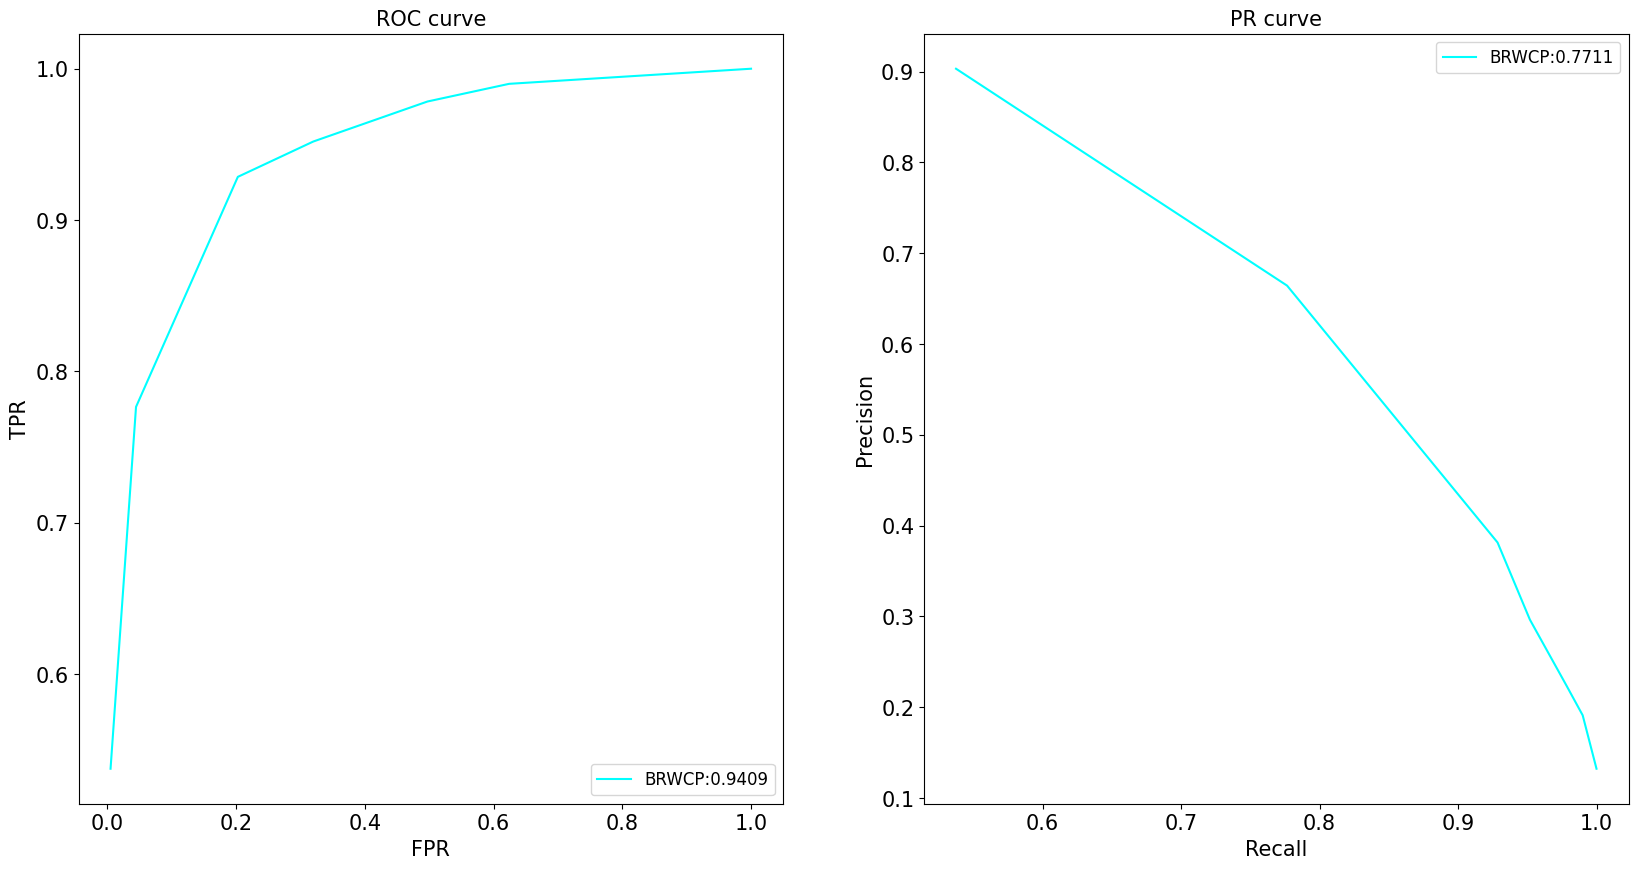

In [20]:
# %load draw_fig.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import *
from tqdm import tqdm
import pylab as Plot

CPC_FPR = np.loadtxt('./result/fpr_list.txt')
CPC_TPR = np.loadtxt('./result/tpr_list.txt')
CPC_RECALL = np.loadtxt('./result/recall_list.txt')
CPC_P = np.loadtxt('./result/precision_list.txt')



plt.figure(1, figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.rcParams['figure.figsize'] = (4, 4)
plt.title('ROC curve', fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)


plt.plot(CPC_FPR, CPC_TPR, 'aqua', label='BRWCP:{:.4f}'.format(auc(CPC_FPR, CPC_TPR)))


plt.legend(loc='lower right', fontsize=12)
# plt.plot(fpr_mean, tpr_mean)


plt.subplot(1, 2, 2)
plt.title('PR curve', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)

plt.plot(CPC_RECALL, CPC_P, 'aqua', label='BRWCP:{:.4f}'.format(auc(CPC_RECALL, CPC_P)+CPC_RECALL[0]*CPC_P[0]))


plt.legend(loc='upper right', fontsize=12)
plt.show()


In [25]:
RR

array([[0.00794195, 0.02572682, 0.07236071, ..., 0.07667294, 0.00881902,
        0.00919508],
       [0.03505823, 0.03821782, 0.05213485, ..., 0.04250746, 0.02900922,
        0.02729177],
       [0.03115649, 0.04167985, 0.06432004, ..., 0.06304175, 0.04182841,
        0.03920246],
       ...,
       [0.01698394, 0.01979472, 0.03332105, ..., 0.02509672, 0.01669663,
        0.01396936],
       [0.02702255, 0.03102028, 0.0451241 , ..., 0.03690058, 0.03026129,
        0.0256429 ],
       [0.01793655, 0.02537913, 0.03619186, ..., 0.02695491, 0.01871322,
        0.01685963]])

# setting2

In [1]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre=np.loadtxt("./source_data/ic4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/ic_simmat_drug.txt")
simpre=np.loadtxt("./source_data/ic_simmat_target.txt")

prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)

group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_d:
        r = group_data1[f,i ] 
        c = np.where(DTI[group_data1[f, i], :] == 1)[0]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting2"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 60.83it/s]


In [2]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
dr_pre=np.loadtxt("./source_data/ic4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/ic_simmat_drug.txt")
simpre=np.loadtxt("./source_data/ic_simmat_target.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p_ic.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d_ic.txt")

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)

group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))
# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting2" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        realvalue[d,p]=reala[d,p]
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in group_data1[f, :] and j in protein_indices :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.18it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.99it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.72it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3359.31it/s]


11.857142857142858
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.9827859431765203
The aupr of prediction is: 0.7929753641666849


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3582.35it/s]


19.238095238095237
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.974336385990721
The aupr of prediction is: 0.801727926141097


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3620.45it/s]


12.857142857142858
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.984592024196177
The aupr of prediction is: 0.81956749217525


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3652.17it/s]


13.380952380952381
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.9895570732000276
The aupr of prediction is: 0.8548008354240643


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3748.87it/s]


8.571428571428571
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.9911105733863224
The aupr of prediction is: 0.8460671706711853


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3651.36it/s]


15.285714285714286
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.9874403900743767
The aupr of prediction is: 0.8667249498885929


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3802.27it/s]


13.952380952380953
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.9831466738553318
The aupr of prediction is: 0.807829018435684


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3815.81it/s]


20.095238095238095
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.9787861062381418
The aupr of prediction is: 0.8252602164164763


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3671.96it/s]


21.0
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.9696580685880105
The aupr of prediction is: 0.7869219673543936


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 3746.33it/s]

177.71428571428572
21 <class 'list'>
<class 'numpy.ndarray'> 204
The auc of prediction is: 0.4789547364425087
The aupr of prediction is: 0.0729689245107843
The auc of prediction is: 0.9336411730167951
The aupr of prediction is: 0.6771736872538623
Runtime: 9.452691316604614


# setting3

In [3]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre=np.loadtxt("./source_data/ic4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/ic_simmat_drug.txt")
simpre=np.loadtxt("./source_data/ic_simmat_target.txt")
prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_p:
        r = np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        c = group_data1_p[f, i]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting3"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.49it/s]


In [4]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
dr_pre=np.loadtxt("./source_data/ic4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/ic_simmat_drug.txt")
simpre=np.loadtxt("./source_data/ic_simmat_target.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p_ic.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d_ic.txt")

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting3" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        realvalue[d,p]=reala[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        RR[d,p]=R[d,p]

y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in drug_indices and j in group_data1_p[f, :] :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.20it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 4564.58it/s]


2.263157894736842
152 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9833264939236661
The aupr of prediction is: 0.9132092711000679


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6074.17it/s]


2.913793103448276
116 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9799855434379001
The aupr of prediction is: 0.9057379248003119


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 5643.25it/s]


3.2481203007518795
133 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9742805021291856
The aupr of prediction is: 0.8897809750657902


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 5377.74it/s]


2.4125874125874125
143 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9786770737556169
The aupr of prediction is: 0.9030276003777421


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6086.01it/s]


2.4
125 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9837482881232384
The aupr of prediction is: 0.9171542796289425


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 5052.65it/s]


2.2158273381294964
139 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9821970037456722
The aupr of prediction is: 0.9123397293833714


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6879.99it/s]


2.9611650485436893
103 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9771147185080866
The aupr of prediction is: 0.8933556177622701


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 7222.13it/s]


2.378640776699029
103 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9785473229852927
The aupr of prediction is: 0.909375434510339


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6352.81it/s]


2.7079646017699117
113 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9740740624672503
The aupr of prediction is: 0.8938000078556959


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 6363.27it/s]

2.2018348623853212
109 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.9827932511347767
The aupr of prediction is: 0.9172792137448301
The auc of prediction is: 0.9788737815371539
The aupr of prediction is: 0.9021757701447292
Runtime: 9.773264646530151


# setting4

In [5]:
import random
import numpy as np
from tqdm import trange
import numpy as np

fold = 10
dr_pre=np.loadtxt("./source_data/ic4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/ic_simmat_drug.txt")
simpre=np.loadtxt("./source_data/ic_simmat_target.txt")

prenum = len(simpre)
drnum = len(simdr)

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

f = 0
for f in trange(fold):
    DTI = np.copy(dr_pre)
    i=0
    while i < group_size1_d:
        r = group_data1[f,i ] 
        c = np.where(DTI[group_data1[f, i], :] == 1)[0]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵

    while i < group_size1_p:
        r = np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        c = group_data1_p[f, i]
        DTI[r, c] = 0
        i += 1  # 得到每次交叉验证中所使用的A矩阵
    np.savetxt("./dataset/DTI_setting4"+str(f)+".txt",DTI)



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 47.96it/s]


In [6]:
# %load run_main.py
import numpy as np
from function import *
from tqdm import trange
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.metrics
import copy
import time
rs = 0.6
n_fold=10
eta=0.7
l_1=5
l_2=5
fr=500
fp=300
K=20
dr_pre=np.loadtxt("./source_data/ic4_admat_dgc.txt").T
simdr=np.loadtxt("./source_data/ic_simmat_drug.txt")
simpre=np.loadtxt("./source_data/ic_simmat_target.txt")

drnum=len(simdr)     #药物的数目
#disnum=len(dr_dis[0])     #副作用的数目
prenum=len(simpre)     #蛋白质的数目


#index_1 = np.loadtxt("./dataset/index_1.txt")
#index_0 = np.loadtxt("./dataset/index_0.txt")
#index = np.hstack((index_1, index_0))     #水平拼接
reala=dr_pre
sr = simdr
sd = simpre/100

RR=np.zeros(dr_pre.shape)       #原始的邻接矩阵
RR_1=np.zeros(dr_pre.shape)       #原始的邻接矩阵
#A = np.hstack((dr_dr, dr_dis, dr_se))       #Fr
#B = np.hstack((pre_pre, pre_dis))         #Fp
#cutdr_dis = SVD(A, fr)    #奇异值分解    Fr'
#cutpre_dis = SVD(B, fp)     #奇异值分解    Fp'
#pre_simdti = cosine_similarity(cutpre_dis, cutpre_dis)    #计算余弦相似度   SrF
#dr_simdti = cosine_similarity(cutdr_dis, cutdr_dis)        #计算余弦相似度   SpF
pre_simdti = np.loadtxt("./source_data/S_FGS_p_ic.txt")
dr_simdti = np.loadtxt("./source_data/S_FGS_d_ic.txt")

# 获取药物的索引（矩阵的行索引）
drug_indices = list(range(dr_pre.shape[0]))
num_d = len(drug_indices)
group_size1_d = int(num_d / fold)
random.seed(10)
random.shuffle(drug_indices)
array_1=np.array(drug_indices)[0:fold*group_size1_d]
group_data1=np.reshape(array_1,(fold,group_size1_d))

# 获取靶点的索引（矩阵的列索引）
protein_indices = list(range(dr_pre.shape[1]))
num_p = len(protein_indices)
group_size1_p = int(num_p / fold)
random.seed(10)
random.shuffle(protein_indices)

array_1_p=np.array(protein_indices)[0:fold*group_size1_p]
group_data1_p=np.reshape(array_1_p,(fold,group_size1_p))

# 记录开始时间
start_time = time.time()

srfp, spfp = pruning(K=K, drug_mat=dr_simdti, target_mat=pre_simdti, miu=eta)
srsp, spsp = pruning(K=K, drug_mat=sr, target_mat=sd, miu=eta)

for f in trange(n_fold):
    a = np.loadtxt("./dataset/DTI_setting4" + str(f) + ".txt")
    #idx=index[f,:]
   
    R = copy.deepcopy(a)
    R = BiRW(R, dr_simdti, pre_simdti, a, rs)        
    for i in trange(l_1):
        R=BiRW(R, srfp, spfp, a, rs/2)
    for i in trange(l_2):
        R=BiRW(R, srsp, spsp, a, rs/2)

    realvalue=np.zeros(R.shape)
    realvalue_1=np.zeros(R.shape)
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        realvalue_1[d,p]=reala[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        realvalue[d,p]=realvalue_1[d,p]
    for i in range(len(group_data1[f, :])): 
        d=group_data1[f, i]
        p=np.where(DTI[group_data1[f, i], :] == 1)[0]
        RR_1[d,p]=R[d,p]
    for i in range(len(group_data1_p[f, :])): 
        d=np.where(dr_pre[:, group_data1_p[f, i]] == 1)[0]
        p=group_data1_p[f, i]
        RR[d,p]=RR_1[d,p]

    
y_true_m = dr_pre.tolist()
y_pre_m = RR.tolist()

tpr_cov=[[] for i in range(n_fold)]
fpr_cov=[[] for i in range(n_fold)]
recall_cov=[[] for i in range(n_fold)]
precision_cov=[[] for i in range(n_fold)]

for f in range(n_fold):
    #idx=index[f,:]
    singal=[[] for i in range(len(y_true_m))]
    singal_test=[[] for i in range(len(y_true_m))]
    for i in trange(len(y_true_m)):
        for j in range(len(y_true_m[0])):
            if i in drug_indices and j in group_data1_p[f, :] :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
            if i in group_data1[f, :] and j in protein_indices :
                singal[i].append(y_true_m[i][j])
                singal_test[i].append(y_pre_m[i][j])
    y_true=singal
    y_pre=singal_test

    idx = []
    tpr_list = []
    fpr_list = []
    recall_list = []
    precision_list = []
    c = 0
    for i in trange(len(y_true)):
        if np.sum(np.array(y_true[i])) == 0:
            c += 1
            continue
        else:
            tpr1, fpr1, precision1, recall1 = tpr_fpr_precision_recall(np.array(y_true[i]), np.array(y_pre[i]))
            fpr_list.append(fpr1)
            tpr_list.append(tpr1)
            precision_list.append(precision1)
            recall_list.append(recall1)
    coverage = []

    for i in tpr_list:
        try:
            coverage.append(i.index(1.0)+1)
        except:
            print('1')
    print(np.mean(np.array(coverage)))

    tpr = equal_len_list(tpr_list)
    print(len(tpr ),type(tpr))
    fpr = equal_len_list(fpr_list)
    precision = equal_len_list(precision_list)
    recall = equal_len_list(recall_list)
    tpr_mean = np.mean(tpr, axis=0)
    tpr_cov[f]=tpr_mean
    print(type(tpr_mean),len(tpr_mean))
    fpr_mean = np.mean(fpr, axis=0)
    fpr_cov[f]=fpr_mean
    recall_mean = np.mean(recall, axis=0)
    recall_cov[f]=recall_mean
    precision_mean = np.mean(precision, axis=0)
    precision_cov[f]=precision_mean
    print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean, tpr_mean))
    print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean, precision_mean)+recall_mean[0]*precision_mean[0])

tpr = equal_len_list(tpr_cov)
fpr = equal_len_list(fpr_cov)
precision = equal_len_list(precision_cov)
recall = equal_len_list(recall_cov)

tpr_mean_snf = np.mean(tpr, axis=0)
fpr_mean_snf = np.mean(fpr, axis=0)
recall_mean_snf = np.mean(recall, axis=0)
precision_mean_snf = np.mean(precision, axis=0)

# 记录结束时间并计算运行时间
end_time = time.time()
runtime = end_time - start_time

print('The auc of prediction is:', sklearn.metrics.auc(fpr_mean_snf, tpr_mean_snf))
print('The aupr of prediction is:', sklearn.metrics.auc(recall_mean_snf, precision_mean_snf)+recall_mean_snf[0]*precision_mean_snf[0])
# 打印灵敏度和运行时间

print('Runtime:', runtime)
#np.savetxt('./result/fpr_list_snf.txt', fpr_mean_snf)
#np.savetxt('./result/tpr_list.txt_snf', tpr_mean_snf)
#np.savetxt('./result/recall_list.txt_snf', recall_mean_snf)
#np.savetxt('./result/precision_list.txt_snf', precision_mean_snf)






100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 15.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.02it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.80it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.66it/s]

100%|███████████████████████████

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1865.60it/s]


17.61875
160 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.48911328225089235
The aupr of prediction is: 0.12835704682243806


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2027.82it/s]


28.536
125 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.5286158538959568
The aupr of prediction is: 0.23689892650910807


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1864.31it/s]


23.855172413793102
145 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.5630545837604451
The aupr of prediction is: 0.21514894648039512


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2048.63it/s]


28.5578231292517
147 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.5858224484946211
The aupr of prediction is: 0.2232587635848721


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2268.64it/s]


27.7007299270073
137 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.7266584170039381
The aupr of prediction is: 0.31895253429027126


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1905.45it/s]


31.137931034482758
145 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.7147124981898161
The aupr of prediction is: 0.3900695322115158


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2153.63it/s]


32.16379310344828
116 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.8338013408231405
The aupr of prediction is: 0.5719765289243277


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2138.21it/s]


40.252252252252255
111 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.7335231180166245
The aupr of prediction is: 0.4831702381413796


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1978.51it/s]


35.08661417322835
127 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.8459621344789545
The aupr of prediction is: 0.6111974900012411


100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 2244.75it/s]

37.275862068965516
116 <class 'list'>
<class 'numpy.ndarray'> 20
The auc of prediction is: 0.8930439159620107
The aupr of prediction is: 0.6543498296063024
The auc of prediction is: 0.6911120431588802
The aupr of prediction is: 0.35106007289012353
Runtime: 12.30445408821106
